### Encode cell-line expression

In [ ]:
# 3 latent dims: [50, 100, 150]
# to compare with corresponding gradients 
# from UMAP and differential gene selection

In [ ]:
# 2023-07-26 update
# Observed 45, 41 minute training initialization on n = 100
# so adding [10, 25] latent dims

### Setup

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Layer
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback
import tensorflow.compat.v1.keras.backend as K
tf.compat.v1.disable_eager_execution() # error with tf 3.11

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# VAE functions
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim), mean=0., stddev=1.0 )
    return mu + K.exp(sigma/2)*eps

class CustomVariationalLayer(Layer):
    """
    Define a custom layer
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(
            x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [11]:
# Loss plot visualization to determine degree of model fitting
def plot_loss(loss_dict, latent_dim, train_file, epochs):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_dict['vs0'], marker='o', linestyle='-', color='b')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.title('CPTAC '+'GEXP'+' VAE Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.annotate(
        'Samples: {}'.format(
            len(train_file))+'\nLatent dim: '+str(latent_dim)+'\nRaw features: {}'.format(len(train_file.columns)), 
                 xy=(0.7, 0.3), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round, pad=0.5', fc='white', ec='black'),
                 fontsize=12)
    plt.savefig('AUC_v1/VAE_loss_plots/dim.'+str(latent_dim)+'_epochs.'+str(epochs)+'_vae_loss.png')
    # plt.close()

In [ ]:
# Note, no loss plots for gene diff and UMAP

### Main

In [4]:
vae_inpt = pd.read_csv('AUC_v1/exprsn_dot_T.tsv',
                      sep = '\t',
                      index_col = 0)

In [5]:
train_file = vae_inpt

In [6]:
scaler = MinMaxScaler()
train_file = pd.DataFrame(
    scaler.fit_transform(train_file),
    columns=train_file.columns,
    index=train_file.index)

#### Mid-experiment feature count decrease  
* adding epochs to loss plot to track iterations  
attempt intentional underfit?

In [20]:
latent_dim = 10
epochs = 50
latent_header_prefix = 'cl_ln_gxp'

In [14]:
latent_dim = 25
epochs = 35
latent_header_prefix = 'cl_ln_gxp'

### Initial schematic version  
10 minute MLP, trnsfrmr training initialization  
at 100k subsample rate for n=50  

40+ minute @ n=100

In [37]:
latent_dim = 50
epochs = 25
latent_header_prefix = 'cl_ln_gxp'

In [43]:
latent_dim = 100
epochs = 15
latent_header_prefix = 'cl_ln_gxp'

In [47]:
latent_dim = 150
epochs = 10
latent_header_prefix = 'cl_ln_gxp'

In [21]:
# Variational autoencoder for feature dimensionality reduction

loss_dict = {}
vs_list = ['vs0']
validation_split = vs_list[0]

features = train_file.columns

original_dim = len(features)
feature_dim = len(features)
latent_dim = latent_dim
batch_size = 50

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(
    latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(
    latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(
    compute_latent, output_shape=(
        latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(
    feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005

kappa = 1
beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

history = vae.fit(train_file,
            epochs=epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  callbacks=[WarmUpCallback(beta, kappa)],
                  verbose=1)
loss_dict[validation_split] = history.history['loss']

encoder = Model(encoder_inputs, z_mean_encoded)
latent_object = pd.DataFrame(
    encoder.predict(train_file),
    index=train_file.index
)
latent_object.index.name = train_file.index.name

# Convert latent object headers to dtype specific strings for input to transformer
new_column_headers = []
for column_header in latent_object.columns:
    new_column_header = latent_header_prefix+'_' + str(column_header)
    new_column_headers.append(new_column_header)
latent_object.columns = new_column_headers

latent_object.to_csv(
    'AUC_v1/VAE_expr_'+str(latent_dim)+'.tsv',
    sep = '\t')
print('VAE done, latent object written to disk')

2023-07-26 14:00:48.725965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-26 14:00:48.789895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-26 14:00:48.827610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train on 1007 samples
Epoch 1/50


2023-07-26 14:00:49.018182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-26 14:00:49.090855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-26 14:00:49.125541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1007/1007 [==============================] - 2s 2ms/sample - loss: 21210.2259
Epoch 2/50
 250/1007 [======>.......................] - ETA: 0s - loss: 20904.5137

2023-07-26 14:00:50.735450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1007/1007 [==============================] - 1s 554us/sample - loss: 20746.3371
Epoch 3/50
1007/1007 [==============================] - 1s 537us/sample - loss: 20269.8906
Epoch 4/50
1007/1007 [==============================] - 1s 521us/sample - loss: 19794.0725
Epoch 5/50
1007/1007 [==============================] - 1s 525us/sample - loss: 19334.0666
Epoch 6/50
1007/1007 [==============================] - 1s 526us/sample - loss: 18850.8273
Epoch 7/50
1007/1007 [==============================] - 1s 517us/sample - loss: 18406.4424
Epoch 8/50
1007/1007 [==============================] - 1s 524us/sample - loss: 17990.4994
Epoch 9/50
1007/1007 [==============================] - 1s 525us/sample - loss: 17552.3471
Epoch 10/50
1007/1007 [==============================] - 1s 519us/sample - loss: 17227.9443
Epoch 11/50
1007/1007 [==============================] - 1s 536us/sample - loss: 16853.0963
Epoch 12/50
1007/1007 [==============================] - 1s 520us/sample - loss: 16530.7857
Epoch 1

/Users/karlberb/miniforge3/envs/tf_M1_py3dot9/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-07-26 14:01:16.596494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


VAE done, latent object written to disk


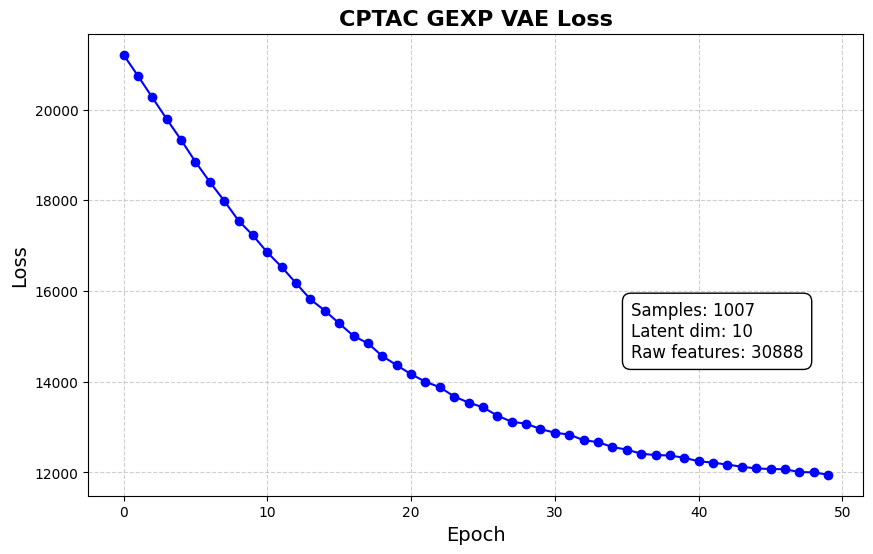

In [22]:
plot_loss(loss_dict, latent_dim, train_file, epochs)

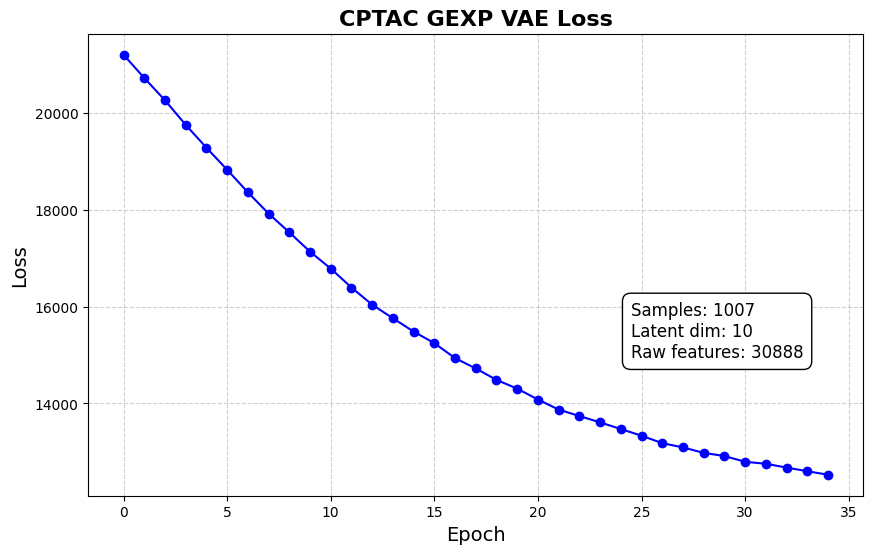

In [19]:
plot_loss(loss_dict, latent_dim, train_file, epochs) # appears slightly under fit

In [ ]:
# Observation: Epochs decrease with increasing latent dimension to maintain shape of loss curve